Here I used the breast cancer dataset from https://www.kaggle.com/merishnasuwal/breast-cancer-prediction-dataset
    
Vectorised implementation of a deep layer neural network

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
%matplotlib inline

In [3]:
df=pd.read_csv('56485_108594_bundle_archive/Breast_cancer_data.csv')

In [4]:
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
mean_radius        569 non-null float64
mean_texture       569 non-null float64
mean_perimeter     569 non-null float64
mean_area          569 non-null float64
mean_smoothness    569 non-null float64
diagnosis          569 non-null int64
dtypes: float64(5), int64(1)
memory usage: 26.8 KB


In [6]:
df.describe()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,1.000000


In [7]:
df.isnull().sum()

mean_radius        0
mean_texture       0
mean_perimeter     0
mean_area          0
mean_smoothness    0
diagnosis          0
dtype: int64

(6.0, 0.0)

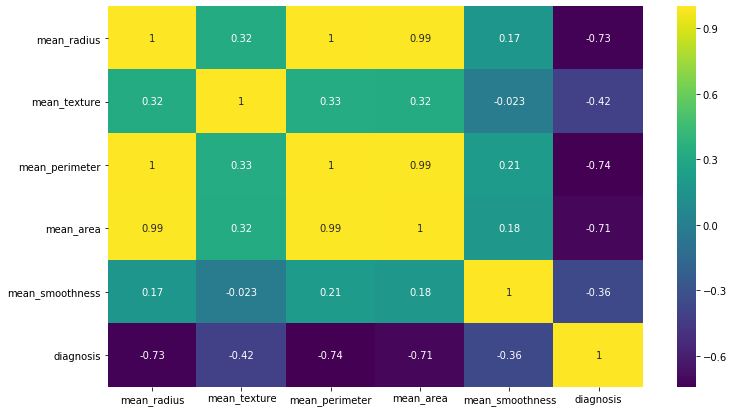

In [8]:
plt.figure(figsize=(12,7))
ax = sns.heatmap(df.corr(),annot=True,cmap='viridis')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [9]:
df['diagnosis'].value_counts()

1    357
0    212
Name: diagnosis, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X=df.drop('diagnosis',axis=1).values
y=df['diagnosis'].values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101)

In [13]:
X.shape

(569, 5)

In [14]:
y.shape

(569,)

Reshaping X to be of dimension: (n,m) and Y to be of dimension: (1,m)

Where n = dimension of input features and m = number of training examples

In [15]:
y_train=y_train.reshape(1,y_train.shape[0]) 
#reshaping y to fit the desired dimensions of (1,m) where m = no. of training examples

In [16]:
y_test=y_test.reshape(1,y_test.shape[0])

In [17]:
y_test.shape

(1, 114)

In [18]:
y_train.shape

(1, 455)

In [19]:
X_train=X_train.reshape(X_train.shape[0], -1).T 
#reshaping X to fit the desired dimensions of (n,m) where n = dimension of input features

In [20]:
X_test=X_test.reshape(X_test.shape[0], -1).T

In [21]:
X_train.shape

(5, 455)

In [22]:
X_test.shape

(5, 114)

Here we create the building blocks of the deep neural network

In [23]:
def initialise_params(layers_dims):
    parameters={}
    L=len(layers_dims)
    
    for l in range(1,L):
        parameters['W'+str(l)]=np.random.randn(layers_dims[l],layers_dims[l-1])*0.01 #W dimensions (l,l-1)
        parameters['b'+str(l)]=np.zeros((layers_dims[l],1)) #b dimensions (l,1). Initialising with 0's won't cause symmetry as b
        
    return parameters

In [24]:
def sigmoid(Z):
    g = 1/(1+np.exp(-Z))
    cache=Z
    return g,cache

In [25]:
def relu(Z):
    g=np.maximum(0,Z)
    assert(g.shape == Z.shape)
    cache=Z
    return g,cache

In [26]:
def sigmoid_deriv(dA,cache):
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [27]:
def relu_deriv(dA,cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [28]:
#Where l is the current layer of the neural network

#Z[l]=W[l].A[l-1]+b[l]
#A[l]=g[l](Z[l]) where g is the activation function sigmoid or relu

#Cache stores the values of Z(from the activation functions), W, b and A(l-1) for implementation of backwards prop later

def lin_activation_forward(A_prev,W,b,activation):
    
    Z=np.dot(W,A_prev)+b
    
    assert(Z.shape == (W.shape[0], A_prev.shape[1]))
    
    if activation=="sigmoid":
        A_this,activation_cache=sigmoid(Z)
        
    elif activation=="relu":
        A_this,activation_cache=relu(Z)
        
    assert(A_this.shape==(W.shape[0],A_prev.shape[1]))
    
    cache = (A_prev, W, b,activation_cache) 
    
    return A_this, cache

In [29]:
def forward_prop(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    for l in range(1, L): #relu activation function for layers 1 to L-1
        A_prev = A 
        A, cache = lin_activation_forward(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],"relu")
        caches.append(cache)
    
    #sigmoid activation for final layer
    AL, cache = lin_activation_forward(A,parameters['W'+str(L)],parameters['b'+str(L)],"sigmoid") #capital L cos final layer
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [30]:
def compute_cost(AL,Y):
    
    m=Y.shape[1]
    
    cost = -(1/m)*np.sum(np.multiply(Y,np.log(AL))+np.multiply(1-Y,np.log(1-AL)))
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost

In [31]:
#dZ[l]=dA[l]*g'[l](Z[l]) where g'[l] is the derivative of the activation function

#dw[l]=(1/m)*dz[l].(A[l-1].T)
#db[l]=(1/m)*np.sum(dZ[l])
#dA[l-1]=(W[l].T).dZ[l]

def linear_activation_backward(dA, cache, activation):
    
    A_prev, W, b, activation_cache = cache
    m = A_prev.shape[1]
    
    if activation == "relu":
        dZ = relu_deriv(dA,activation_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_deriv(dA,activation_cache)
        
        
    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [32]:
def backward_prop(AL, Y, caches):

    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    dAL = -(np.divide(Y,AL)-np.divide(1-Y,1-AL)) #input for the backward prop
   
    #calculating gradients for final layer with activation function sigmoid_deriv
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL,current_cache,"sigmoid")
    
    #calculating gradients for the other layers with activation function relu_deriv
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)],current_cache,"relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [33]:


def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W"+str(l+1)]-np.dot(learning_rate,grads["dW"+str(l+1)])
        parameters["b" + str(l+1)] = parameters["b"+str(l+1)]-np.dot(learning_rate,grads["db"+str(l+1)])
    return parameters

In [34]:
layers_dims=[X_train.shape[0],5,7,1]

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):

    costs = []                         # keep track of cost
    
    parameters = initialise_params(layers_dims)

    #forward prop -> compute cost -> back prop -> update params -> repeat
    for i in range(0, num_iterations):
        AL, caches = forward_prop(X,parameters)
        cost = compute_cost(AL,Y)
        grads = backward_prop(AL,Y,caches)
        parameters = update_parameters(parameters,grads,learning_rate)

                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.693205
Cost after iteration 100: 0.677899
Cost after iteration 200: 0.651324
Cost after iteration 300: 0.626909
Cost after iteration 400: 0.573837
Cost after iteration 500: 0.567387
Cost after iteration 600: 0.527354
Cost after iteration 700: 0.499665
Cost after iteration 800: 0.475163
Cost after iteration 900: 0.454151
Cost after iteration 1000: 0.440362
Cost after iteration 1100: 0.416162
Cost after iteration 1200: 0.405154
Cost after iteration 1300: 0.398074
Cost after iteration 1400: 0.386881
Cost after iteration 1500: 0.382319
Cost after iteration 1600: 0.376430
Cost after iteration 1700: 0.364690
Cost after iteration 1800: 0.369998
Cost after iteration 1900: 0.358413
Cost after iteration 2000: 0.356606
Cost after iteration 2100: 0.353805
Cost after iteration 2200: 0.350114
Cost after iteration 2300: 0.349398
Cost after iteration 2400: 0.341827


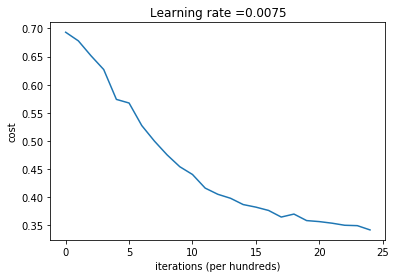

In [35]:
parameters = L_layer_model(X_train, y_train, layers_dims, num_iterations = 2500, print_cost = True)